In [56]:
!pip install POT

In [307]:
import numpy as np
from collections import deque
import random
import networkx as nx
import matplotlib.pyplot as plt
import ot

In [341]:
def adj_to_dist(adj_matrix):

    n = len(adj_matrix)
    distance_matrix = np.full((n, n), np.inf)

    for start in range(n):
        #BFS
        queue = deque([start])
        distances = [-1] * n
        distances[start] = 0

        while queue:
            current = queue.popleft()
            for neighbor in range(n):
                if adj_matrix[current][neighbor] == 1 and distances[neighbor] == -1:
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        for end in range(n):
            if distances[end] != -1:
                distance_matrix[start][end] = distances[end]

    return distance_matrix.astype(int)

In [342]:
def plot_graph(adj_matrix):

    # グラフオブジェクト作成
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray',
            node_size=800, font_size=12, font_weight='bold')

    plt.title("Graph")
    plt.show()

In [343]:
def gen_random_adj_matrix(n, edge_prob=0.3, seed=None):

    # n : ノード数
    # edge_prob : 各辺が存在する確率
    # seed : ランダムシード

    if seed is not None:
        np.random.seed(seed)

    # 上三角行列にランダムな0/1を生成（対角は0）
    upper_tri = np.triu(np.random.rand(n, n) < edge_prob, k=1).astype(int)

    # 対称行列に変換（上三角 + 転置）
    adj_matrix = upper_tri + upper_tri.T

    return adj_matrix

In [344]:
def p_lazy_srw(adj_matrix, p=0.99):

    # p : idleness parameter

    n = len(adj_matrix)
    distributions = np.zeros((n, n))

    for i in range(n):
        dist = np.zeros(n)
        neighbors = np.where(adj_matrix[i] > 0)[0]
        deg = len(neighbors)

        if deg == 0:
            dist[i] = 1.0
        else:
            dist[i] = p
            dist[neighbors] = (1 - p) / deg

        distributions[i] = dist

    return distributions

In [345]:
def Wasserstein_distance_matrix(adj_matrix, p=0.99):

    # 各ノードについてのp-lazy-srwを導出

    n = len(adj_matrix)
    distributions = p_lazy_srw(adj_matrix,p)
    dist_matrix = adj_to_dist(adj_matrix)

    Wdistance_matrix=np.zeros((n,n))

    for i in range(n):
        for j in range(i+1, n):
            # Wasserstein距離を計算
            Wdistance = ot.emd2(distributions[i], distributions[j], dist_matrix)
            Wdistance_matrix[i, j] = Wdistance
            Wdistance_matrix[j, i] = Wdistance

    return Wdistance_matrix

In [346]:
def adj_to_curvature(adj_matrix):

    n=len(adj_matrix)
    p=0.99
    dist_matrix = adj_to_dist(adj_matrix)
    Wdist_matrix = Wasserstein_distance_matrix(adj_matrix, p)
    curvature_matrix = np.zeros_like(Wdist_matrix)

    for i in range(n):
        for j in range(i+1, n):
            if dist_matrix[i, j] != 0:
                curvature_matrix[i, j] = (1 - ( Wdist_matrix[i, j] / dist_matrix[i, j] )) / (1-p)
                curvature_matrix[j, i] = curvature_matrix[i, j]

            else:
                curvature_matrix[i, j] = -np.inf
                curvature_matrix[j, i] = -np.inf

    return curvature_matrix

In [362]:
def plot_graph_with_curvature(adj_matrix, curvature_matrix):

    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G,seed=42)

    edge_colors = []
    for u, v in G.edges():
        edge_weight = curvature_matrix[u, v]
        # 距離が小さいと青、大きいと赤に着色
        edge_colors.append(plt.cm.coolwarm(edge_weight))

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12, font_weight='bold', edge_color=edge_colors, width=2)
    plt.title("Graph with Edge Colors Based on Cruvature")
    plt.show()

In [348]:
adj_matrix_1 = gen_random_adj_matrix(n=15, edge_prob=0.4, seed=5)
print(adj_matrix_1)

[[0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
 [0 0 1 0 0 0 1 1 1 1 1 1 0 0 1]
 [1 1 0 0 1 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 1 0 0 1 1 1 0 0 1 1 1 1 0]
 [0 0 0 0 1 0 1 0 1 1 1 0 0 1 1]
 [0 1 1 0 1 1 0 1 0 0 0 0 1 1 0]
 [0 1 0 1 1 0 1 0 1 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 1 0 0 1 0 0 1 1]
 [1 1 0 1 0 1 0 0 0 0 0 0 1 0 0]
 [1 1 1 1 1 1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 1 0 0 1 0 0 0 0 1]
 [1 0 0 0 1 1 1 0 1 0 0 0 0 0 1]
 [0 1 1 0 0 1 0 0 1 0 0 1 1 1 0]]


In [349]:
distance_matrix_1 = adj_to_dist(adj_matrix_1)
print("距離行列:")
print(distance_matrix_1)

距離行列:
[[0 2 1 2 2 2 2 2 1 1 1 3 2 1 2]
 [2 0 1 2 2 2 1 1 1 1 1 1 2 2 1]
 [1 1 0 2 1 2 1 2 2 2 1 2 2 2 1]
 [2 2 2 0 2 2 2 1 1 1 1 3 2 2 2]
 [2 2 1 2 0 1 1 1 2 2 1 1 1 1 2]
 [2 2 2 2 1 0 1 2 1 1 1 2 2 1 1]
 [2 1 1 2 1 1 0 1 2 2 2 2 1 1 2]
 [2 1 2 1 1 2 1 0 1 2 2 2 2 2 2]
 [1 1 2 1 2 1 2 1 0 2 1 2 2 1 1]
 [1 1 2 1 2 1 2 2 2 0 2 2 1 2 2]
 [1 1 1 1 1 1 2 2 1 2 0 2 2 2 2]
 [3 1 2 3 1 2 2 2 2 2 2 0 2 2 1]
 [2 2 2 2 1 2 1 2 2 1 2 2 0 2 1]
 [1 2 2 2 1 1 1 2 1 2 2 2 2 0 1]
 [2 1 1 2 2 1 2 2 1 2 2 1 1 1 0]]


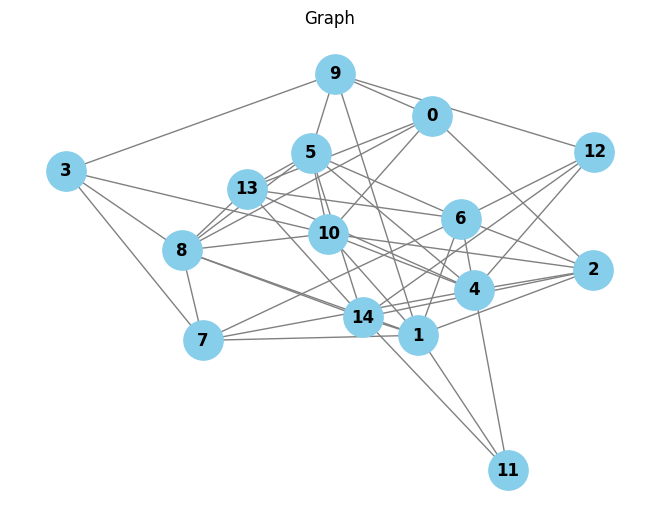

In [350]:
plot_graph(adj_matrix_1)

In [351]:
curvature_matrix_1 = adj_to_curvature(adj_matrix_1)
print(curvature_matrix_1)

[[0.         0.6875     0.43333333 0.675      0.625      0.78571429
  0.64285714 0.6        0.45       0.2        0.57142857 0.66666667
  0.6        0.43333333 0.64285714]
 [0.6875     0.         0.625      0.6875     0.8125     0.74107143
  0.5        0.5        0.5        0.2        0.46428571 0.375
  0.6875     0.6875     0.53571429]
 [0.43333333 0.625      0.         0.58333333 0.45833333 0.78571429
  0.5        0.73333333 0.75       0.65       0.5952381  0.66666667
  0.75       0.83333333 0.42857143]
 [0.675      0.6875     0.58333333 0.         0.5625     0.71428571
  0.57142857 0.45       0.375      0.25       0.39285714 0.66666667
  0.625      0.54166667 0.48214286]
 [0.625      0.8125     0.45833333 0.5625     0.         0.57142857
  0.82142857 0.3        0.6875     0.625      0.32142857 0.25
  0.25       0.5        0.8125    ]
 [0.78571429 0.74107143 0.78571429 0.71428571 0.57142857 0.
  0.57142857 0.71428571 0.57142857 0.28571429 0.57142857 0.64285714
  0.78571429 0.80952381

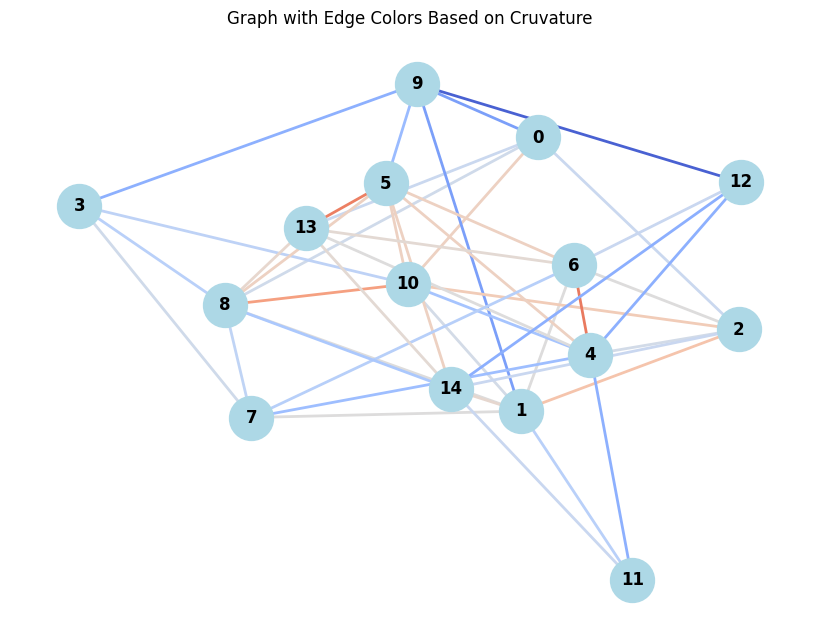

In [352]:
plot_graph_with_curvature(adj_matrix_1, curvature_matrix_1)

# 曲率が大きい辺ほど赤く、小さい辺ほど青く表示されている

In [353]:
#明示的なクラスターを含む構成

def generate_clustered_graph(n_clusters, cluster_size, inter_cluster_prob=0.1, intra_cluster_prob=0.9, seed=None):

    # n_clusters: クラスターの数
    # cluster_size: 各クラスター内のノード数
    # inter_cluster_prob: クラスター間の接続確率
    # intra_cluster_prob: クラスター内の接続確率
    # seed: ランダムシード

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    n = n_clusters * cluster_size  # 総ノード数
    adj_matrix = np.zeros((n, n))  # 隣接行列の初期化

    # 各クラスター内の接続を作成
    for cluster in range(n_clusters):
        start = cluster * cluster_size
        end = (cluster + 1) * cluster_size
        for i in range(start, end):
            for j in range(i + 1, end):
                if random.random() < intra_cluster_prob:  # クラスター内での接続
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1

    # クラスター間の接続を作成
    for cluster1 in range(n_clusters):
        for cluster2 in range(cluster1 + 1, n_clusters):
            start1, end1 = cluster1 * cluster_size, (cluster1 + 1) * cluster_size
            start2, end2 = cluster2 * cluster_size, (cluster2 + 1) * cluster_size
            for i in range(start1, end1):
                for j in range(start2, end2):
                    if random.random() < inter_cluster_prob:  # クラスター間での接続
                        adj_matrix[i, j] = 1
                        adj_matrix[j, i] = 1

    return adj_matrix

In [354]:
n_clusters = 8
cluster_size = 4
adj_matrix_2 = generate_clustered_graph(n_clusters, cluster_size, inter_cluster_prob=0.02, intra_cluster_prob=1, seed=2)
print(adj_matrix_2)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


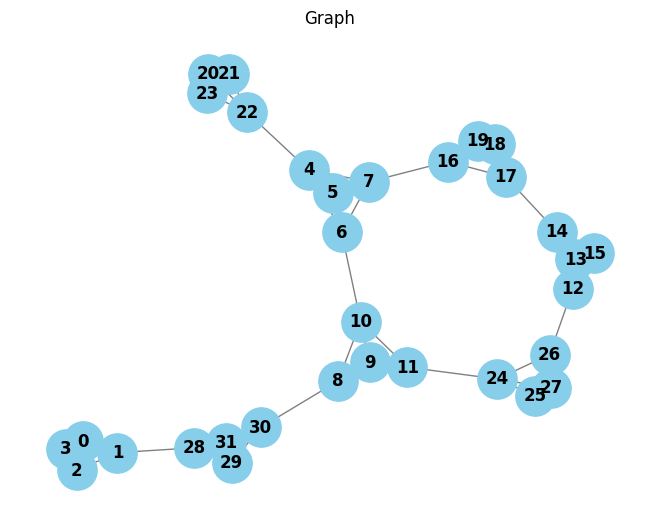

In [355]:
plot_graph(adj_matrix_2)

In [356]:
curvature_matrix_2 = adj_to_curvature(adj_matrix_2)
print(curvature_matrix_2)

[[ 0.          0.83333333  1.33333333 ...  0.22222222  0.11111111
   0.22222222]
 [ 0.83333333  0.          0.83333333 ... -0.08333333 -0.25
  -0.08333333]
 [ 1.33333333  0.83333333  0.         ...  0.22222222  0.11111111
   0.22222222]
 ...
 [ 0.22222222 -0.08333333  0.22222222 ...  0.          0.83333333
   1.33333333]
 [ 0.11111111 -0.25        0.11111111 ...  0.83333333  0.
   0.83333333]
 [ 0.22222222 -0.08333333  0.22222222 ...  1.33333333  0.83333333
   0.        ]]


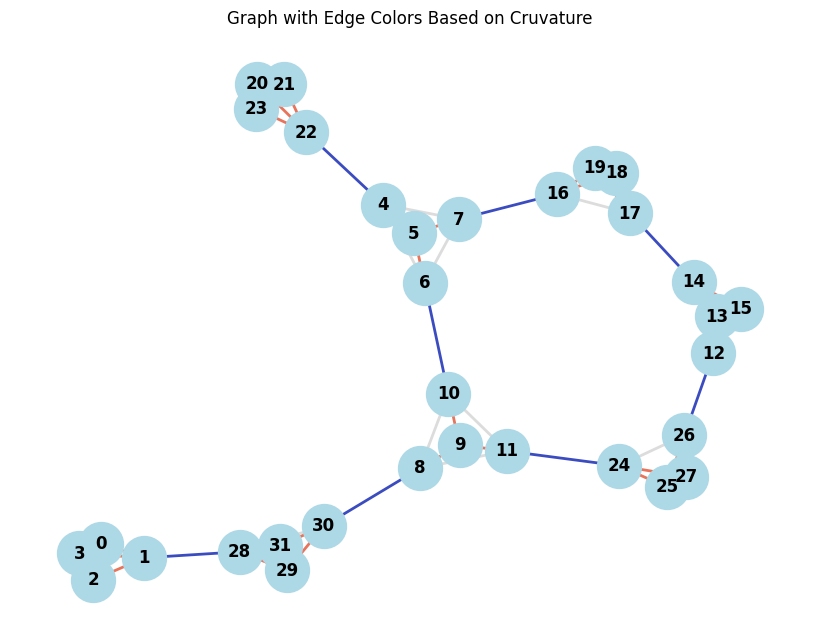

In [357]:
plot_graph_with_curvature(adj_matrix_2, curvature_matrix_2)

# 曲率が大きい辺ほど赤く、小さい辺ほど青く表示されている

In [358]:
#完全グラフの例

adj_matrix_3 = gen_random_adj_matrix(n=15, edge_prob=1)
print(adj_matrix_3)

[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]]


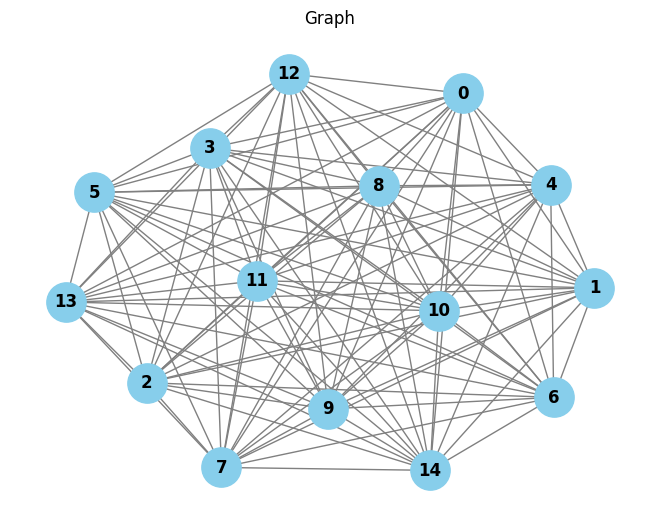

In [359]:
plot_graph(adj_matrix_3)

In [360]:
curvature_matrix_3 = adj_to_curvature(adj_matrix_3)
print(curvature_matrix_3)

[[0.         1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857]
 [1.07142857 0.         1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857]
 [1.07142857 1.07142857 0.         1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857]
 [1.07142857 1.07142857 1.07142857 0.         1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857]
 [1.07142857 1.07142857 1.07142857 1.07142857 0.         1.07142857
  1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857 1.07142857 1.07142857]
 [1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 0.
  1.07142857 1.07142857 1.07142857 1.07142857 1.07142857 1.07142857
  1.07142857

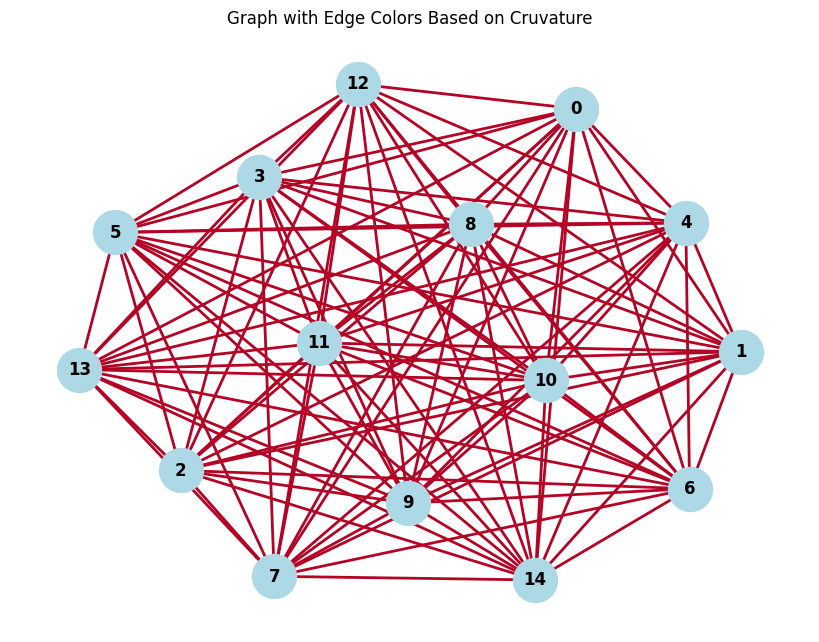

In [361]:
plot_graph_with_curvature(adj_matrix_3, curvature_matrix_3)

# 任意の辺は繋がりが密接なので、赤く表示されている